<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/ML_AI24_HT7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 7: Fraud Detection Competition**

Добро пожаловать на финальное домашнее задание курса! Домашнее задание направлено на систематизацию всех знаний, полученных в процессе учебы.

В нём Вы потренируетесь применять навыки построения пайплайнов машинного обучения, приобретенные в курсе от точки разведочного анализа данных до построения и валидации моделей машинного обучения.

## **Задача**
**Вы будете решать задачу определения фрода:**

https://www.kaggle.com/competitions/fraud-detection-24

**Вам нужно будет:**
- в jupyter notebook провести исследование данных;
- в нём же построить модели и оценить их качество;
- отправить посылку на Kaggle.

Более подробное описание шагов - в ноутбуке ниже.

## **Оценивание и баллы**
- В EDA и во всей работе будут оцениваться полнота и **выводы**;
- При обучении моделей старайтесь обоснованно подходить к их выбору, избегая простого перебора;

**Максимальный балл** - 10 (+ бонусы за Kaggle, см. ниже).


Мягкий дедлайн (окончание соревнования на Kaggle): **15 марта 23:59**


# **Базовое решение и пример формирования файла под submission**


In [1]:
from catboost import CatBoostClassifier
import pandas as pd
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_transaction = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')
sample_submission = pd.read_csv('sample_submission.csv')

df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')
df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')

In [4]:
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_train.shape, df_test.shape

((417559, 432), (172981, 431))

### **Примечания:**

**1. Оценка качества и Submission File**
- Ответом является число от 0 до 1, метрикой качества - AUC-ROC.
- Структура Submission File:
 - для каждого значения *TransactionID* в тестовых данных вы должны предсказать **вероятность** для столбца *isFraud*.
 - в файле у вас должно быть две колонки: `TransactionID` и`isFraud`  **для каждой транзакции в датасете**.

**2. Объем данных**

Поскольку набор данных объемный, могут быть проблемы с переполнением памяти в Collab. Для решения проблемы можете использовать функцию из [этого ноутбука](https://colab.research.google.com/drive/18u75eyFGEoyeWJ_MbsLkcPa6gv2tNI8G#scrollTo=V2L1Nl5CTMMl), разобравшись, что она делает с данными.

# **Задание 1 (2 балла)**

Проведите EDA (разведочный анализ данных):
* проанализируйте признаки, их особенности и связь с целевой переменной
* проанализируйте целевую переменную
* оцените степень попарной взаимосвязи признаков, а также связи признаков и целевой переменной
* по результатам исследований сделайте необходимую обработку данных (удаление дублей, работа с пропусками, с категориальными столбцами (если они есть), работа с аномалиями, другие преобразования признаков)

Важно, что EDA всегда сопровождается выводами - не забудьте об этом.

### **1.1 Пропуски и дубликаты**

In [5]:
def reduce_mem_usage(df, df_test):
    NAlist = []  # Keeps track of columns that have missing values filled in.
    
    for col in tqdm(df.columns):
        if df[col].dtype != object:  # Exclude strings and other non-numeric types
            # Check for missing values  
            # Check if the column can be converted to an integer
            # First, fill NA with a temporary value to avoid errors
            temp_filled = df[col].fillna(0)  # Временное заполнение для проверки
            col_as_int = temp_filled.astype(np.int64)
            diff = (temp_filled - col_as_int).sum()
            
            if np.abs(diff) < 0.01:  # Column can be converted to integer
                # Fill NA with the most frequent value (mode)
                mode_value = df[col].mode()[0]
                df[col].fillna(mode_value, inplace=True)
                if col in df_test.columns:
                    df_test[col].fillna(mode_value, inplace=True)
                
                # Convert to the smallest possible integer type
                col_min = df[col].min()
                col_max = df[col].max()
                
                if col_min >= 0:  # Unsigned integers
                    if col_max < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif col_max < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif col_max < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:  # Signed integers
                    if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
            else:  # Column cannot be converted to integer
                # Fill NA with the median value
                median_value = df[col].median()
                df[col].fillna(median_value, inplace=True)
                if col in df_test.columns:
                    df_test[col].fillna(median_value, inplace=True)
                # Convert to float32
                df[col] = df[col].astype(np.float32)
                
    return df, df_test, NAlist

In [6]:
df_train, df_test, NA_df = reduce_mem_usage(df_train, df_test)

100%|██████████| 432/432 [00:04<00:00, 101.87it/s]


In [7]:
numeric_columns = df_train.select_dtypes(include='number').columns
categorical_columns = df_train.select_dtypes(exclude='number').columns

In [8]:
# Проверка на дубликаты
print("Количество дубликатов в train данных:", df_train.duplicated().sum())
df_train.drop_duplicates(inplace=True)

Количество дубликатов в train данных: 276


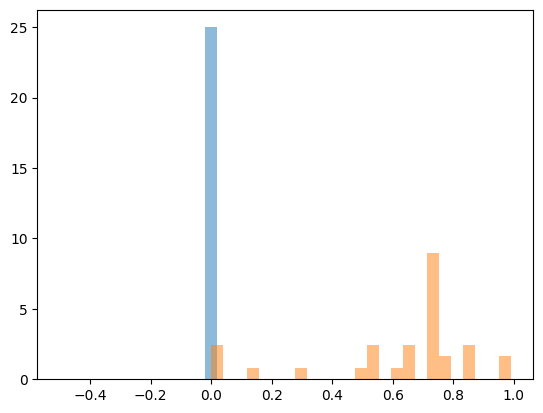

Column,id_27,id_23,id_33,id_30,id_34,DeviceInfo,id_16,R_emaildomain,id_31,DeviceType,...,V102,V101,V100,V99,V98,V97,V96,V95,V94,V164
Missing Values,0.990524,0.990524,0.861439,0.85119,0.851017,0.779624,0.761337,0.751272,0.741276,0.740886,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
missing_values = df_train.isnull().mean().to_frame('Missing Values').T
missing_values.columns.name = 'Column'
missing_values.index = ['Missing Values']
plt.hist(missing_values[numeric_columns].values.ravel(), bins=25, density=True, alpha = 0.5)
plt.hist(missing_values[categorical_columns].values.ravel(), bins=25, density=True, alpha = 0.5)
plt.show()
missing_values.T.sort_values(ascending=False, by = 'Missing Values').T

### **1.2 Целевая переменная**

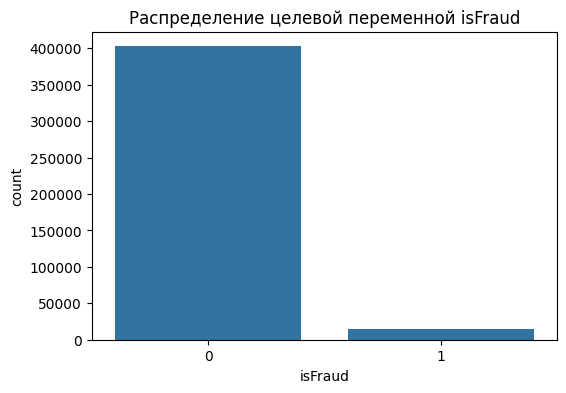

Распределение целевой переменной:
isFraud
0    0.964722
1    0.035278
Name: proportion, dtype: float64


In [10]:
# Распределение целевой переменной
plt.figure(figsize=(6, 4))
sns.countplot(x='isFraud', data=df_train)
plt.title('Распределение целевой переменной isFraud')
plt.show()

# Статистика по целевой переменной
print("Распределение целевой переменной:")
print(df_train['isFraud'].value_counts(normalize=True))

### **1.3 Попарная связь переменных**

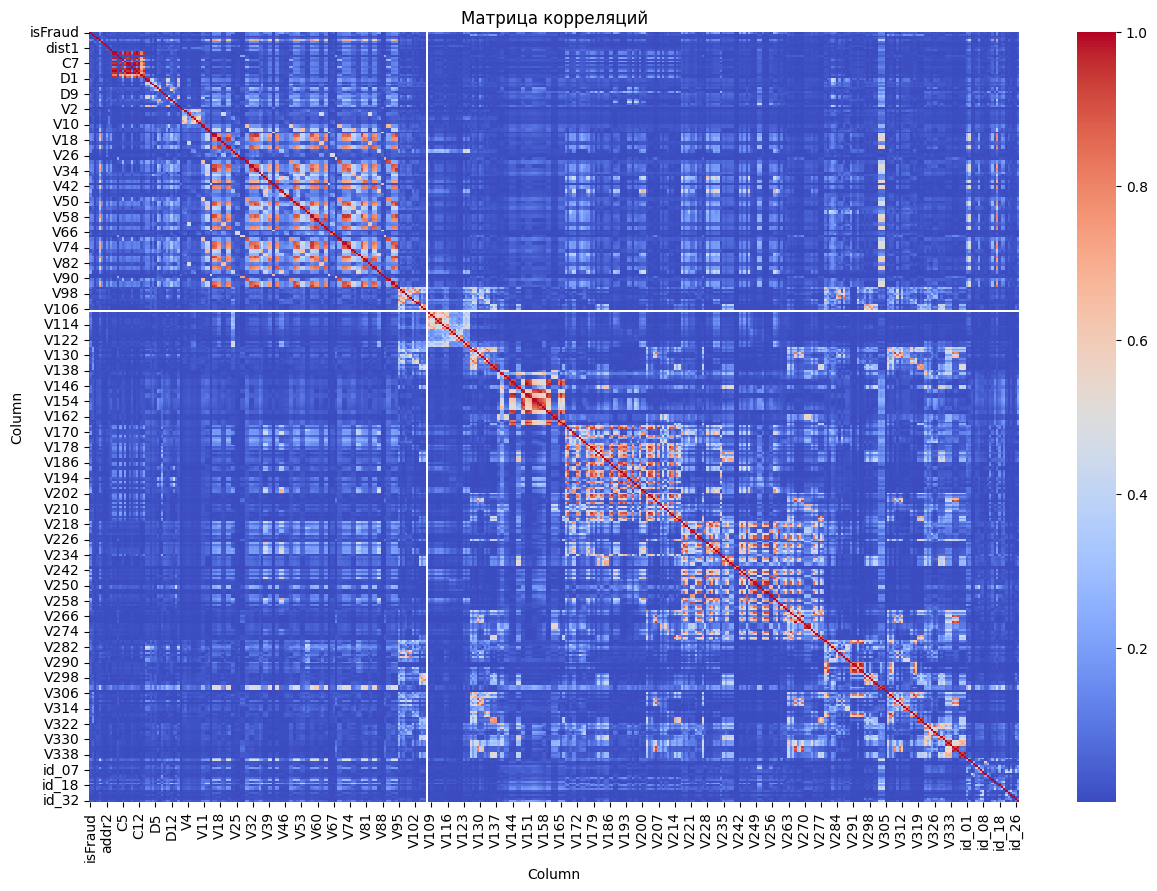

In [11]:
# Матрица корреляций для числовых признаков
corr_matrix = df_train.select_dtypes(include='number').corr().abs()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Матрица корреляций')
plt.show()

In [12]:
# Пример: удаление признаков с корреляцией > 0.95
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print("Признаки для удаления:", to_drop)

Признаки для удаления: ['C2', 'C4', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C14', 'D2', 'V11', 'V16', 'V18', 'V22', 'V28', 'V30', 'V32', 'V33', 'V34', 'V40', 'V43', 'V49', 'V52', 'V58', 'V60', 'V64', 'V70', 'V71', 'V72', 'V73', 'V74', 'V81', 'V85', 'V91', 'V93', 'V94', 'V137', 'V145', 'V150', 'V151', 'V152', 'V154', 'V155', 'V156', 'V159', 'V160', 'V163', 'V165', 'V182', 'V192', 'V193', 'V196', 'V199', 'V203', 'V207', 'V212', 'V222', 'V225', 'V229', 'V244', 'V249', 'V251', 'V253', 'V254', 'V256', 'V269', 'V272', 'V278', 'V292', 'V294', 'V295', 'V304', 'V317', 'V321', 'V333', 'V336', 'V339']


In [13]:
df_train = df_train.drop(to_drop, axis=1)
df_test = df_test.drop(to_drop, axis=1)

In [14]:
corr_matrix.isFraud.sort_index(ascending=False)

Column
isFraud    1.000000
id_32      0.033164
id_26      0.001704
id_25      0.006983
id_24      0.006867
             ...   
C13        0.006989
C12        0.032077
C11        0.025823
C10        0.028847
C1         0.027941
Name: isFraud, Length: 401, dtype: float64

Пропуски в численных признаках были заполнены медианой, а в категориальных-int признаках заполнены модой. Пропуски в категориальных-object признаках (там где их под 100%) будут заполнены строкой `missing`. Удалены дубликаты. С целью уменьшить количество признаков были удалены сильно коррелирующий признаки (>0.95). Сильную линейную связь между целевой переменной и признаками нет

# **Задание 2 (3 балла)**

Обучите несколько ML-моделей для решения поставленной задачи.
Оцените их качество двумя способами:

1) на кросс-валидации

2) на лидерборде

Подберите число фолдов на кросс-валидации так, чтобы метрики, которые вы видите, были максимально близки на кросс-валидации и на лидерборде.

По результатам экспериментов постройте таблицу:
* в каждой строке таблицы - результаты одной модели
* по столбцам: качество на кросс-валидации, качество на лидерборде, модель с гиперпараметрами
Полученную таблицу вставьте картинкой прямо в ноутбук после ячеек с кодом. Сделайте текстовые выводы.

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [16]:
X_train = df_train.drop('isFraud', axis=1)
X_train = X_train.fillna('missing')
y_train = df_train['isFraud'].values

df_test.fillna('missing', inplace=True)

In [17]:
numeric_columns = list(X_train.select_dtypes(include='number').columns)
categorical_columns = list(X_train.select_dtypes(exclude='number').columns)

In [18]:
# Создаем пайплайн для обработки числовых данных
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor_numeric = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns)
    ])

preprocessor_all = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', 'passthrough', categorical_columns)   
    ])

In [19]:
def save_results(path, model, df_test):
    predictions = model.predict_proba(df_test)
    sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions[:, 1]})
    sub.to_csv(path, index=False)

def to_dataframe(X, columns):
    return pd.DataFrame(X, columns=columns)

### **2.1 Логистическая регрессия (только числовые признаки)**

In [48]:
model_1 = Pipeline(steps=[
    ('preprocessor', preprocessor_numeric),
    ('classifier', LogisticRegression())
])

model_1.fit(X_train[numeric_columns], y_train)

save_results('baseline_LogisticRegression.csv', model_1, df_test[numeric_columns])

In [21]:
cross_val_score(model_1, X_train[numeric_columns], y_train, cv=3, n_jobs=-1, verbose=1, scoring='roc_auc').mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   31.8s finished


0.8118314673563162

### **2.2 Случаный лес (только числовые признаки)**

In [49]:
model_2 = Pipeline(steps=[
    ('preprocessor', preprocessor_numeric),
    ('classifier', RandomForestClassifier(max_depth=15))
])

model_2.fit(X_train[numeric_columns], y_train)

save_results('baseline_RandomForestClassifier.csv', model_2, df_test[numeric_columns])

In [23]:
cross_val_score(model_2, X_train[numeric_columns], y_train, cv=3, n_jobs=-1, verbose=1, scoring='roc_auc').mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.6min finished


0.856383314872565

### **2.2 CatBoost (только числовые признаки)**

In [50]:
model_3 = Pipeline(steps=[
    ('preprocessor', preprocessor_numeric),
    ('classifier', CatBoostClassifier(iterations=10000, learning_rate=0.1, verbose=1000, task_type='GPU'))
])

model_3.fit(X_train[numeric_columns], y_train)

save_results('baseline_CatBoostClassifier_num_only.csv', model_3, df_test[numeric_columns])

0:	learn: 0.5309137	total: 10.3ms	remaining: 1m 43s
1000:	learn: 0.0649131	total: 8.99s	remaining: 1m 20s
2000:	learn: 0.0532891	total: 20.9s	remaining: 1m 23s
3000:	learn: 0.0457597	total: 32.9s	remaining: 1m 16s
4000:	learn: 0.0396770	total: 42.3s	remaining: 1m 3s
5000:	learn: 0.0349014	total: 51.7s	remaining: 51.7s
6000:	learn: 0.0308138	total: 1m 1s	remaining: 40.8s
7000:	learn: 0.0272520	total: 1m 10s	remaining: 30.3s
8000:	learn: 0.0243271	total: 1m 20s	remaining: 20.1s
9000:	learn: 0.0216955	total: 1m 30s	remaining: 10s
9999:	learn: 0.0193644	total: 1m 39s	remaining: 0us


In [25]:
cross_val_score(model_1, X_train[numeric_columns], y_train, cv=3, scoring='roc_auc').mean()

0.8118808481761534

### **2.3 CatBoost (все признаки)**

In [51]:
model_4 = Pipeline(steps=[
    ('preprocessor', preprocessor_all),
    ('to_dataframe', FunctionTransformer(to_dataframe, kw_args={'columns': numeric_columns + categorical_columns})),
    ('classifier', CatBoostClassifier(iterations=1000, cat_features=list(categorical_columns), learning_rate=0.1, verbose=100, task_type='GPU'))
])

model_4.fit(X_train, y_train)

save_results('baseline_CatBoostClassifier_all.csv', model_4, df_test)

0:	learn: 0.5353749	total: 316ms	remaining: 5m 16s
100:	learn: 0.0866737	total: 9.84s	remaining: 1m 27s
200:	learn: 0.0798008	total: 19.5s	remaining: 1m 17s
300:	learn: 0.0754394	total: 29s	remaining: 1m 7s
400:	learn: 0.0725637	total: 38.4s	remaining: 57.4s
500:	learn: 0.0700187	total: 47.9s	remaining: 47.7s
600:	learn: 0.0681251	total: 57.4s	remaining: 38.1s
700:	learn: 0.0661526	total: 1m 7s	remaining: 28.6s
800:	learn: 0.0643635	total: 1m 16s	remaining: 19s
900:	learn: 0.0629761	total: 1m 26s	remaining: 9.48s
999:	learn: 0.0616158	total: 1m 35s	remaining: 0us


In [27]:
cross_val_score(model_4, X_train, y_train, cv=3, scoring='roc_auc').mean()

0:	learn: 0.5318675	total: 215ms	remaining: 3m 35s
100:	learn: 0.0845119	total: 21.1s	remaining: 3m 7s
200:	learn: 0.0766931	total: 42.7s	remaining: 2m 49s
300:	learn: 0.0723871	total: 1m 5s	remaining: 2m 31s
400:	learn: 0.0689040	total: 1m 27s	remaining: 2m 11s
500:	learn: 0.0662607	total: 1m 49s	remaining: 1m 49s
600:	learn: 0.0637638	total: 2m 12s	remaining: 1m 27s
700:	learn: 0.0616402	total: 2m 36s	remaining: 1m 6s
800:	learn: 0.0597159	total: 3m 1s	remaining: 45.1s
900:	learn: 0.0581131	total: 3m 24s	remaining: 22.4s
999:	learn: 0.0566428	total: 3m 46s	remaining: 0us
0:	learn: 0.5260962	total: 198ms	remaining: 3m 17s
100:	learn: 0.0869607	total: 20.3s	remaining: 3m
200:	learn: 0.0799538	total: 40.4s	remaining: 2m 40s
300:	learn: 0.0754072	total: 1m 2s	remaining: 2m 24s
400:	learn: 0.0724729	total: 1m 30s	remaining: 2m 15s
500:	learn: 0.0700704	total: 2m 1s	remaining: 2m
600:	learn: 0.0677120	total: 2m 28s	remaining: 1m 38s
700:	learn: 0.0656346	total: 2m 53s	remaining: 1m 13s
800

0.8867085779272411

|model|cross-val score|leaderboard|
|-|-|-|
| LogisticRegression| 0.8118| 0.8208|
|RandomForest|0.8563|0.8672|
|CatBoost (numeric only)|0.8118|0.8694|
|CatBoost (all)|0.8867|0.8972|

# **Задание 3 (2 балла)**

Попробуйте подойти к задаче как к поиску аномалий.

1) Поищите аномалии (фрод) различными рассмотренными в курсе методами и сделайте прогноз на тестовых данных.

Результатом также будет таблица:
* по строкам - методы поиска аномалий
* по столбцам - качество вашего решения на leaderboard

2) Попробуйте встроить поиск аномалий и их удаление в ML-пайплайн: найдите аномалии и что-нибудь с ними сделайте до обучения моделей (можно удалить их, а можно использовать в качестве дополнительных признаков - попробуйте разные стратегии). Результат проверьте на кросс-валидации и на лидерборде, сделайте выводы.

In [28]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [29]:
clf = IsolationForest(max_samples='auto', contamination=0.05, random_state=42)
clf.fit(X_train[numeric_columns])
clf_predictions = -clf.score_samples(df_test[numeric_columns])

sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': clf_predictions})
sub.to_csv('submission_anomalies_isolation_forest.csv', index=False)

In [30]:
ocs = OneClassSVM(nu=0.05, kernel='linear', max_iter=100, gamma='scale', )
ocs.fit(X_train[numeric_columns])
ocs_predictions = -ocs.score_samples(df_test[numeric_columns])

sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': ocs_predictions})
sub.to_csv('submission_anomalies_one_class_svm.csv', index=False)

|Model|leaderboard|
|-|-|
|IsolationForest|0.7595|
|OneClassSVM|0.3585|

In [33]:
X_train_with_anomlies = X_train
X_train_with_anomlies['is_anomaly'] = clf.predict(X_train[numeric_columns])

model_1 = CatBoostClassifier(iterations=1000, cat_features=list(categorical_columns), learning_rate=0.1, verbose=100, task_type='GPU')

cross_val_score(model_1, X_train_with_anomlies, y_train, cv=3, verbose=1, scoring='roc_auc').mean()

0:	learn: 0.5225439	total: 300ms	remaining: 4m 59s
100:	learn: 0.0845001	total: 16.8s	remaining: 2m 29s
200:	learn: 0.0769146	total: 35.2s	remaining: 2m 20s
300:	learn: 0.0721444	total: 54.7s	remaining: 2m 6s
400:	learn: 0.0686487	total: 1m 13s	remaining: 1m 50s
500:	learn: 0.0658792	total: 1m 32s	remaining: 1m 32s
600:	learn: 0.0634601	total: 1m 50s	remaining: 1m 13s
700:	learn: 0.0612090	total: 2m 6s	remaining: 54.2s
800:	learn: 0.0593326	total: 2m 21s	remaining: 35.2s
900:	learn: 0.0575971	total: 2m 36s	remaining: 17.2s
999:	learn: 0.0560263	total: 2m 52s	remaining: 0us
0:	learn: 0.5302977	total: 327ms	remaining: 5m 26s
100:	learn: 0.0875488	total: 14.6s	remaining: 2m 9s
200:	learn: 0.0799458	total: 25.3s	remaining: 1m 40s
300:	learn: 0.0754720	total: 33s	remaining: 1m 16s
400:	learn: 0.0724498	total: 40.8s	remaining: 1m
500:	learn: 0.0698464	total: 48.7s	remaining: 48.5s
600:	learn: 0.0677552	total: 56.4s	remaining: 37.4s
700:	learn: 0.0656728	total: 1m 4s	remaining: 27.3s
800:	lea

0.8877081728729088

# **Задание 4 (1 балл)**

Сделайте кластеризацию различными способами. Результаты кластеризации используйте для улучшения ML-решений:

1) Номера кластеров закодируйте (OHE или target-encoding) и добавьте как новые признаки

2) При использовании DBSCAN / HDBSCAN предсказанный шум можно трактовать как найденную аномалию и также добавить ее как новый признак

Проведите различные эксперименты. Проверьте как эти подходы влияют на качество прогнозов по кросс-валидации и на лидерборде, сделайте выводы.

In [34]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [35]:
def clustering(df, numeric_columns, n_clusters=5):
    df_copy = df[numeric_columns].copy()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(df_copy)
    df_copy['kmeans_cluster'] = kmeans_labels
    encoder = OneHotEncoder(sparse_output=False, drop='first', dtype='int')
    kmeans_encoded = encoder.fit_transform(df_copy[['kmeans_cluster']])
    df_kmeans = pd.concat([df, pd.DataFrame(kmeans_encoded, columns=[f'kmeans_{i}' for i in range(kmeans_encoded.shape[1])], index=df.index)], axis=1)
    return df_kmeans, kmeans

In [36]:
X_kmeans, kmeans = clustering(X_train, numeric_columns, n_clusters=128)

In [37]:
cross_val_score(model_4, X_kmeans, y_train, cv=3, verbose=1, scoring='roc_auc').mean()

0:	learn: 0.5318676	total: 125ms	remaining: 2m 4s
100:	learn: 0.0845119	total: 7.81s	remaining: 1m 9s
200:	learn: 0.0766803	total: 15.2s	remaining: 1m
300:	learn: 0.0723720	total: 22.7s	remaining: 52.7s
400:	learn: 0.0689086	total: 30.1s	remaining: 44.9s
500:	learn: 0.0660635	total: 40.4s	remaining: 40.2s
600:	learn: 0.0637475	total: 58.2s	remaining: 38.6s
700:	learn: 0.0615339	total: 1m 17s	remaining: 33.1s
800:	learn: 0.0597240	total: 1m 35s	remaining: 23.7s
900:	learn: 0.0580609	total: 1m 53s	remaining: 12.4s
999:	learn: 0.0563871	total: 2m 10s	remaining: 0us
0:	learn: 0.5260963	total: 326ms	remaining: 5m 25s
100:	learn: 0.0869607	total: 19.6s	remaining: 2m 54s
200:	learn: 0.0799538	total: 38.9s	remaining: 2m 34s
300:	learn: 0.0754072	total: 57.5s	remaining: 2m 13s
400:	learn: 0.0723221	total: 1m 15s	remaining: 1m 52s
500:	learn: 0.0698587	total: 1m 33s	remaining: 1m 33s
600:	learn: 0.0676119	total: 1m 51s	remaining: 1m 14s
700:	learn: 0.0654442	total: 2m 12s	remaining: 56.3s
800:	l

0.8884896450905337

## **Задание 5 (1 балл)**

Примените какой-нибудь (один любой) AutoML фреймворк для решения поставленной задачи.

Отправьте AutoML-прогноз на kaggle и посмотрите на качество модели. Сделайте текстовые выводы.

In [38]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from sklearn.datasets import load_breast_cancer

'nlp' extra dependency package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


In [39]:
task = Task("binary")

automl = TabularAutoML(
    task=task,
    timeout=600,  # Время на выполнение (в секундах)
    cpu_limit=4,  # Количество ядер CPU
    general_params={"use_algos": [["lgb", "lgb_tuned", "cb", "cb_tuned"]]}  # Используемые алгоритмы
)

In [40]:
oof_pred = automl.fit_predict(train_data = df_train, roles={'target':'isFraud'})

In [41]:
test_pred = automl.predict(df_test, return_all_predictions=True)

In [42]:
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': test_pred.data[:, 1]})
sub.to_csv('submission_auto_ml.csv', index=False)

Качество на лидерборде: 0.8552

# **Задание 6 (1 балл)**

Весь курс мы работали в Google Colab. Но всегда должны быть запасные варианты, где Вы будете обучать модели.

Среди вариантов есть:
* ваша локальная машина
* kaggle notebooks
* yandex cloud
и другие.

Кроме привычного Google Colab выберите из списка выше один любой альтернативный вариант и проведите эксперимент:

* Прогоните ваш лучший по качеству по результатам заданий 2-4 ML-пайплайн заново в Google Colab и с помощью библиотек (например, при помощи библиотеки time) замерьте время обучения и отдельно время инференса на тестовых данных

* Прогоните этот пайплайн на выбранном альтернативном сервисе/локальной машине и также замерьте время обучения и инференса.

Текстом напишите выводы: опишите, какое альтернативное место для обучения моделей Вы использовали? Прикрепите прямо в ноутбук скриншот с экраном кода в альтернативном сервисе/на локальной машине. Также в виде таблицы приведите сравнение времени обучения и инференса в колабе и в альтернативном месте. Сделайте выводы.

In [43]:
import time

In [44]:
start = time.time()
model_4.fit(X_train, y_train)
print(f'fit: {time.time() - start}')

0:	learn: 0.5353749	total: 270ms	remaining: 4m 29s
100:	learn: 0.0866737	total: 16.1s	remaining: 2m 23s
200:	learn: 0.0798202	total: 27.8s	remaining: 1m 50s
300:	learn: 0.0756245	total: 37.3s	remaining: 1m 26s
400:	learn: 0.0725679	total: 46.7s	remaining: 1m 9s
500:	learn: 0.0700757	total: 56.2s	remaining: 55.9s
600:	learn: 0.0681263	total: 1m 5s	remaining: 43.7s
700:	learn: 0.0661538	total: 1m 15s	remaining: 32.1s
800:	learn: 0.0644921	total: 1m 24s	remaining: 21s
900:	learn: 0.0629853	total: 1m 34s	remaining: 10.3s
999:	learn: 0.0616273	total: 1m 43s	remaining: 0us
fit: 122.15393376350403


In [45]:
start = time.time()
model_4.predict(df_test)
print(f'predict: {time.time() - start}')

predict: 5.322488069534302


|Место|fit (c)|predict (c)|
|-|-|-|
|VSСode локально|168.1808|4.8077|
|Google Collab|166.1208|8.5580|

Все домашки по ML я делал локально, так что даже как-то забыл как пользоваться коллабом и было очень трудно замерить время в нем, так как постоянно заканчивался объем ОЗУ. Да и коллабовская GPU всегда слетала, а без GPU эта моделька обучаетмя около часа

На самом деле достататочно большой разброс времени от запуска к запуску. Постарался подобрать плюс-минус среднее

# **Бонус: за Kaggle и стремление к хорошим скорам (2 балла)**

В этом домашнем задании Ваша цель - не просто выполнить шаги выше, но и построить максимально хорошую по качеству модель.

**К 10 вы можете получить до двух дополнительных баллов:**

* За попадание в топ-20% на private leaderboard — +1 дополнительный балл к оценке
* За попадание в топ-5 мест на private leaderboard — + еще один дополнительный балл к оценке (то есть суммарно 2 дополнительных балла)

**ВАЖНО!!!**

Эти баллы ставятся до мягкого дедлайна по соревнованию. После мягкого дедлайна лидерборд не обновляется, и дополнительные баллы не ставятся.

Успехов!

In [ ]:
# не забудьте прикрепить скриншоты лидерборда, пожалуйста